In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from haversine import haversine

sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

import platform
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)

import scipy as sp
import statsmodels.api as sm # statsmodel 기본 import
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms 
import sklearn as sk
from patsy import dmatrix

import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
train = pd.read_csv("train.csv")
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [3]:
train.tail(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,198


##### 데이터 전처리
- date 분리 : date / month / weekday / time 추가
- distance 추가

##### date 분리 : date / month / weekday / time 추가

In [4]:
pickup_datetime_dt = pd.to_datetime(train["pickup_datetime"])
dropoff_datetime_dt = pd.to_datetime(train["dropoff_datetime"])

train["pickup_datetime"] = pickup_datetime_dt   #datetime64 형식으로 바꿔줌
train["dropoff_datetime"] = dropoff_datetime_dt #datetime64 형식으로 바꿔줌

train["pickup_date"] = train["pickup_datetime"].dt.date              #date only
train["dropoff_date"] = train["dropoff_datetime"].dt.date            #date only

train["pickup_month"] = train["pickup_datetime"].dt.month            #month only
train["dropoff_month"] = train["dropoff_datetime"].dt.month          #month only

train["pickup_weekday"] = train["pickup_datetime"].dt.weekday        #weekday only (요일)
train["dropoff_weekday"] = train["dropoff_datetime"].dt.weekday      #weekday only (요일)

train["pickup_hour"] = train["pickup_datetime"].dt.hour              #hour only
train["dropoff_hour"] = train["dropoff_datetime"].dt.hour            #hour only

##### distance 추가

In [5]:
### 승하차 위치 데이터 tuple로 묶기 - pickup_loc / dropoff_loc로 리턴

In [6]:
pickup_lat = tuple(train["pickup_latitude"])
pickup_lng = tuple(train["pickup_longitude"])
dropoff_lat = tuple(train["dropoff_latitude"])
dropoff_lng = tuple(train["dropoff_longitude"])

In [7]:
pickup_loc = tuple(zip(pickup_lat, pickup_lng))
dropoff_loc = tuple(zip(dropoff_lat, dropoff_lng))

In [8]:
len(pickup_loc), len(dropoff_loc)

(1458644, 1458644)

In [12]:
### pickup_loc & dropoff_loc 으로 직선거리 구하기

In [9]:
distance = []
for i in range(len(pickup_loc)):
    distance.append(haversine(pickup_loc[i], dropoff_loc[i]))

In [10]:
train["distance"] = distance

In [11]:
len(distance)

1458644

In [12]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_month,dropoff_month,pickup_weekday,dropoff_weekday,pickup_hour,dropoff_hour,distance
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02,3.516818e+00,3.517178e+00,3.050375e+00,3.054422e+00,1.360648e+01,1.359890e+01,3.440864e+00
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03,1.681038e+00,1.681217e+00,1.954039e+00,1.956599e+00,6.399693e+00,6.483682e+00,4.296538e+00
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02,2.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,9.000000e+00,9.000000e+00,1.231837e+00
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,1.400000e+01,1.400000e+01,2.093717e+00
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,1.900000e+01,1.900000e+01,3.875337e+00
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06,6.000000e+00,7.000000e+00,6.000000e+00,6.000000e+00,2.300000e+01,2.300000e+01,1.240909e+03


##### 2. distance ~ trip_duration 관계 : pickup_dropoff

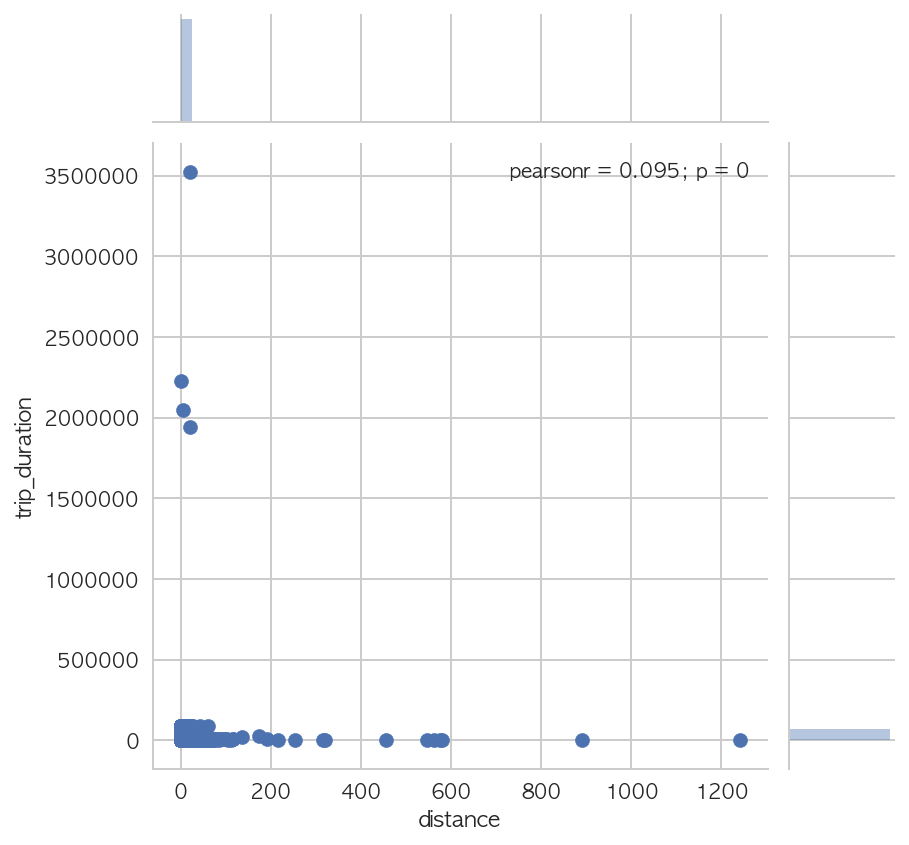

In [13]:
#duration과 distance의 아웃라이어 구간에 대한 재정의가 필요

sns.jointplot(x="distance", y="trip_duration", data=train)
plt.show()

In [14]:
# trip_duration ~ distance 기본 회귀분석.
model_ds = sm.OLS.from_formula("trip_duration ~ distance", train)
result_ds = model_ds.fit()
print(result_ds.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                 1.322e+04
Date:                Sat, 10 Mar 2018   Prob (F-statistic):               0.00
Time:                        06:27:35   Log-Likelihood:            -1.4554e+07
No. Observations:             1458644   AIC:                         2.911e+07
Df Residuals:                 1458642   BIC:                         2.911e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    561.9630      5.531    101.607      0.0

##### 3. speed ~ trip_duration 관계 : pickup_dropoff

In [15]:
train["avg_speed_h"] = 1000 * train["distance"] / train["trip_duration"]

In [16]:
train["avg_speed_h"].describe()

count    1.458644e+06
mean     4.006447e+00
std      4.160423e+00
min      0.000000e+00
25%      2.533687e+00
50%      3.553327e+00
75%      4.956920e+00
max      2.576344e+03
Name: avg_speed_h, dtype: float64

In [17]:
train_speed_duration = train[["trip_duration", "avg_speed_h"]]
train_speed_duration.tail()

,trip_duration,avg_speed_h
1458639,778,1.574653
1458640,655,9.236390
1458641,764,10.241631
1458642,373,2.929126
1458643,198,5.727485


#### trip_duration ~ distance + avg_speed_h+ C(pickup_hour) + 0

In [19]:
model = sm.OLS.from_formula("trip_duration ~ distance + avg_speed_h+ C(pickup_hour) + 0", train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     859.7
Date:                Sat, 10 Mar 2018   Prob (F-statistic):               0.00
Time:                        06:29:01   Log-Likelihood:            -1.4550e+07
No. Observations:             1458644   AIC:                         2.910e+07
Df Residuals:                 1458618   BIC:                         2.910e+07
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
C(pickup_hour)[0]    789.5487     23

#### trip_duration ~ distance + avg_speed_h+ C(pickup_hour) + C(pickup_weekday) + 0

In [20]:
model = sm.OLS.from_formula("trip_duration ~ distance + avg_speed_h+ C(pickup_hour) + C(pickup_weekday) + 0", train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     695.1
Date:                Sat, 10 Mar 2018   Prob (F-statistic):               0.00
Time:                        06:30:09   Log-Likelihood:            -1.4550e+07
No. Observations:             1458644   AIC:                         2.910e+07
Df Residuals:                 1458612   BIC:                         2.910e+07
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
C(pickup_hour)[0]        725

#### trip_duration ~ distance + avg_speed_h+ C(pickup_hour) + C(pickup_weekday) + C(pickup_month) + 0

In [21]:
model = sm.OLS.from_formula("trip_duration ~ distance + avg_speed_h + pickup_hour + C(pickup_weekday) + C(pickup_month) + 0", train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1530.
Date:                Sat, 10 Mar 2018   Prob (F-statistic):               0.00
Time:                        06:30:31   Log-Likelihood:            -1.4550e+07
No. Observations:             1458644   AIC:                         2.910e+07
Df Residuals:                 1458629   BIC:                         2.910e+07
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
C(pickup_weekday)[0]   720.6408 

#### trip_duration ~ log1p(distance) + log1p(avg_speed_h) + abs.sin(pickup_hour) + 0

In [24]:
model = sm.OLS.from_formula("np.log1p(trip_duration) ~ np.log1p(distance) + np.log1p(avg_speed_h)+ abs(np.sin(pickup_hour)) + 0", train)
result = model.fit()
print(result.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.942
Model:                                 OLS   Adj. R-squared:                  0.942
Method:                      Least Squares   F-statistic:                 7.965e+06
Date:                     Sat, 10 Mar 2018   Prob (F-statistic):               0.00
Time:                             06:31:47   Log-Likelihood:            -2.7210e+06
No. Observations:                  1458644   AIC:                         5.442e+06
Df Residuals:                      1458641   BIC:                         5.442e+06
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

#### trip_duration ~ log1p(distance) + abs(np.sin(pickup_hour)) + 0 
- 현재 모델 : r-square 92 / cond 3.82 / F-statistic 8.349e+06
- passenger_count 추가시 : r-square 0.931 / cond 6.32 / F-statistic 6.571e+06

In [45]:
model = sm.OLS.from_formula("np.log1p(trip_duration) ~ np.log1p(distance) + abs(np.sin(pickup_hour)) + 0", train)
result = model.fit()
print(result.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.920
Model:                                 OLS   Adj. R-squared:                  0.920
Method:                      Least Squares   F-statistic:                 8.349e+06
Date:                     Sat, 10 Mar 2018   Prob (F-statistic):               0.00
Time:                             07:17:38   Log-Likelihood:            -2.9646e+06
No. Observations:                  1458644   AIC:                         5.929e+06
Df Residuals:                      1458642   BIC:                         5.929e+06
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

#### F검정을 사용한 변수 중요도 비교 

In [35]:
model = sm.OLS.from_formula("trip_duration ~ distance + avg_speed_h + pickup_longitude + pickup_latitude + pickup_month + pickup_weekday + pickup_hour + passenger_count", data=train)
result = model.fit()
sm.stats.anova_lm(result, typ=2)

,sum_sq,df,F,PR(>F)
distance,4.931638e+11,1.0,18242.799517,0.000000e+00
avg_speed_h,2.120601e+11,1.0,7844.390118,0.000000e+00
pickup_longitude,4.048016e+07,1.0,1.497416,2.210695e-01
pickup_latitude,1.288962e+08,1.0,4.768044,2.899291e-02
pickup_month,4.046803e+08,1.0,14.969673,1.092577e-04
pickup_weekday,5.673404e+07,1.0,2.098669,1.474276e-01
pickup_hour,8.921362e+07,1.0,3.300133,6.927448e-02
passenger_count,1.910173e+09,1.0,70.659908,4.248043e-17
Residual,3.943178e+13,1458635.0,NaN,NaN
